In [ ]:
import os
os.makedirs("/root/.kaggle/", exist_ok=True)

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

import shutil
shutil.move("kaggle (1).json", "/root/.kaggle/kaggle.json")

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json


In [ ]:

# Download ASL Dataset
!kaggle datasets download -d grassknoted/asl-alphabet

# Unzip the dataset
!unzip asl-alphabet.zip -d asl_dataset


Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_dataset/asl_alphabet_train/asl_alphabet_train

In [ ]:
import os
print(os.listdir()) # to list the files in the current directory

['.config', 'asl_dataset', 'asl-alphabet.zip', 'sample_data']


In [ ]:
import os

# Check ASL Dataset
asl_dir = '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train'
print("ASL Dataset:", os.listdir(asl_dir))

ASL Dataset: ['E', 'D', 'P', 'L', 'Q', 'Y', 'T', 'V', 'B', 'W', 'space', 'J', 'C', 'X', 'Z', 'S', 'N', 'F', 'G', 'I', 'U', 'A', 'M', 'H', 'O', 'R', 'K', 'nothing', 'del']


In [ ]:
import shutil

# Folders to delete
extras = ['nothing', 'space', 'del']
for folder in extras:
    folder_path = os.path.join(asl_dir, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted: {folder}")

Deleted: nothing
Deleted: space
Deleted: del


In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_labels = list(train_data.class_indices.keys())
num_classes = len(class_labels)


Found 62400 images belonging to 26 classes.
Found 15600 images belonging to 26 classes.


In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.show()

def evaluate_model(model, val_data, model_name):
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    print(f"\n📊 Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=class_labels, yticklabels=class_labels, annot=False, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), preds.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.grid(True); plt.show()

# EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

📌 EfficientNetB0 Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,216,893 (16.09 MB)

 Trainable params: 167,322 (653.60 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 176s 74ms/step - accuracy: 0.0374 - loss: 3.2724 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 122s 63ms/step - accuracy: 0.0400 - loss: 3.2589 - val_accuracy: 0.0385 - val_loss: 3.2585
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 127s 65ms/step - accuracy: 0.0383 - loss: 3.2585 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 127s 65ms/step - accuracy: 0.0384 - loss: 3.2585 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 123s 63ms/step - accuracy: 0.0402 - loss: 3.2584 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 6/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 124s 64ms/step - accuracy: 0.0366 - loss: 3.2582 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 7/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 121s 62ms/step - accuracy: 0.0379 - loss: 3.2582 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 8/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 124s 63ms/step - accuracy: 

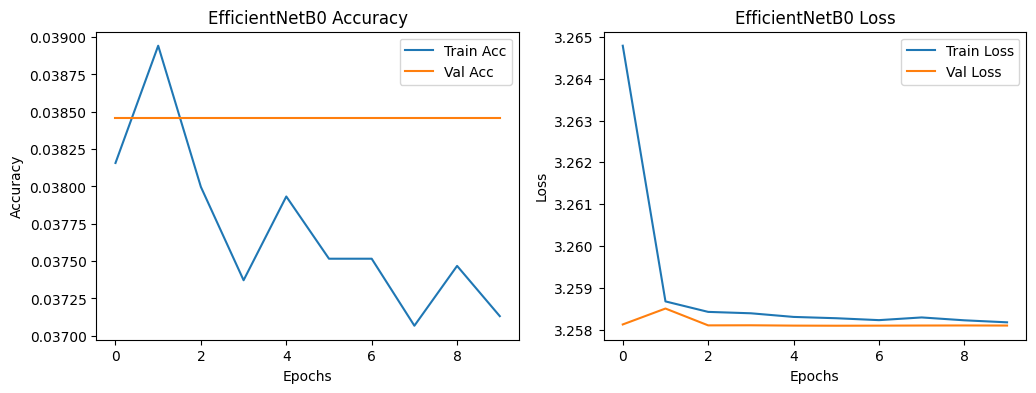

488/488 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step

📊 Classification Report - EfficientNetB0
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.04      1.00      0.07       600
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       600
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


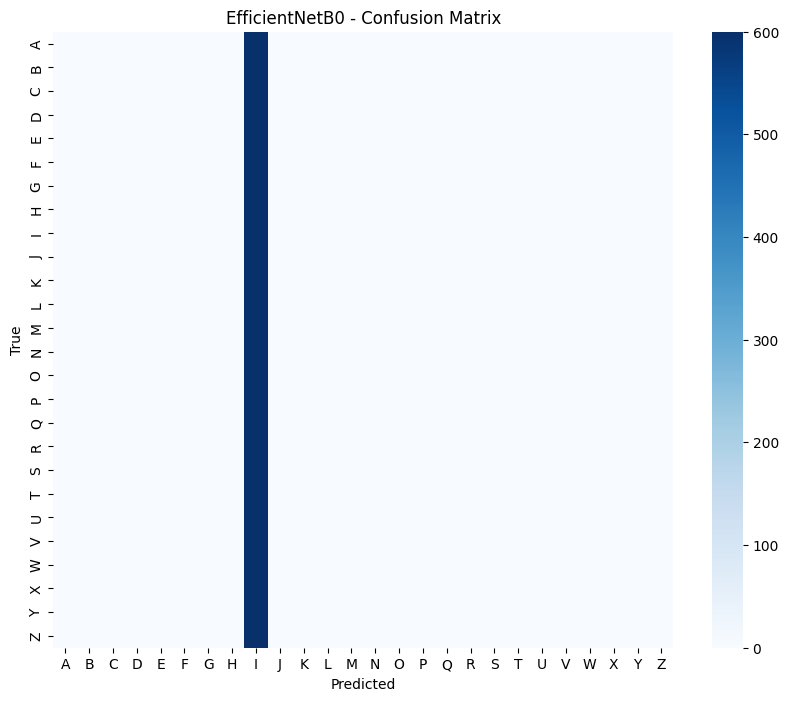

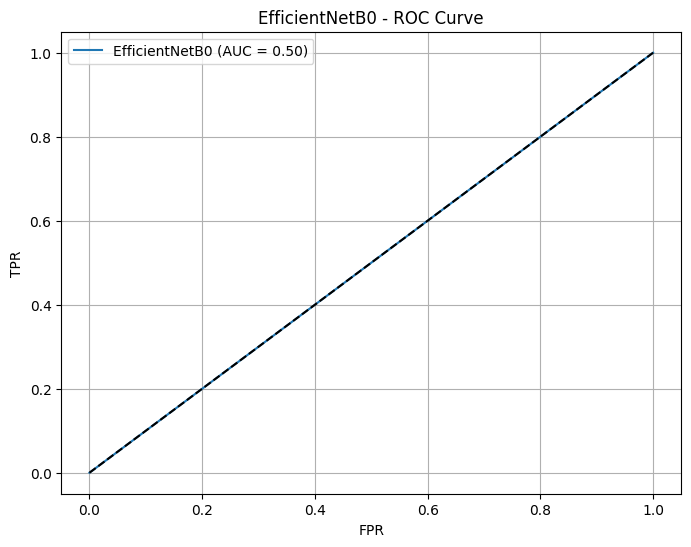

In [ ]:
def train_efficientnet():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n📌 EfficientNetB0 Summary:")
    model.summary()

    start = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=10)
    print("⏱ Time taken:", round(time.time() - start, 2), "sec")

    plot_history(history, 'EfficientNetB0')
    evaluate_model(model, val_data, 'EfficientNetB0')
    model.save("efficientnetb0_asl.h5")
    return history.history['val_accuracy'][-1]

acc_efficientnet = train_efficientnet()

# ResNet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

📌 ResNet50 Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,853,338 (90.99 MB)

 Trainable params: 265,626 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 226s 109ms/step - accuracy: 0.0446 - loss: 3.3465 - val_accuracy: 0.0438 - val_loss: 3.2253
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 205s 105ms/step - accuracy: 0.0753 - loss: 3.1779 - val_accuracy: 0.1050 - val_loss: 3.1539
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 204s 105ms/step - accuracy: 0.1016 - loss: 3.0592 - val_accuracy: 0.1121 - val_loss: 3.0963
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 205s 105ms/step - accuracy: 0.1259 - loss: 2.9613 - val_accuracy: 0.1190 - val_loss: 3.0594
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 204s 105ms/step - accuracy: 0.1476 - loss: 2.8943 - val_accuracy: 0.1180 - val_loss: 3.0241
Epoch 6/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 204s 105ms/step - accuracy: 0.1661 - loss: 2.8385 - val_accuracy: 0.1308 - val_loss: 2.9928
Epoch 7/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 204s 105ms/step - accuracy: 0.1798 - loss: 2.7943 - val_accuracy: 0.1654 - val_loss: 2.9716
Epoch 8/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 205s 105ms/step - ac

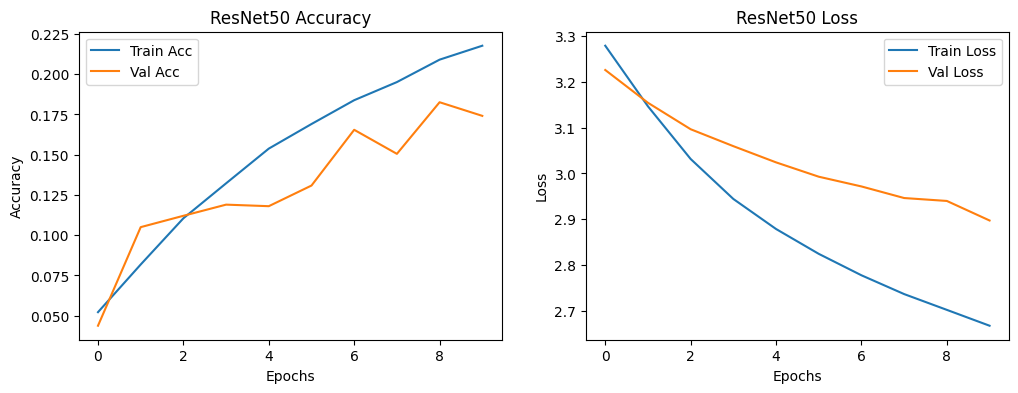

488/488 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step

📊 Classification Report - ResNet50
              precision    recall  f1-score   support

           A       0.37      0.09      0.15       600
           B       0.85      0.34      0.49       600
           C       0.66      0.47      0.55       600
           D       0.63      0.56      0.59       600
           E       0.00      0.00      0.00       600
           F       0.95      0.60      0.73       600
           G       0.46      0.13      0.20       600
           H       0.06      0.00      0.00       600
           I       0.36      0.05      0.09       600
           J       0.23      0.24      0.24       600
           K       0.64      0.29      0.40       600
           L       0.74      0.42      0.53       600
           M       0.06      0.02      0.03       600
           N       0.05      0.69      0.09       600
           O       0.06      0.05      0.05       600
           P       0.75      0.01      0.01       600
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


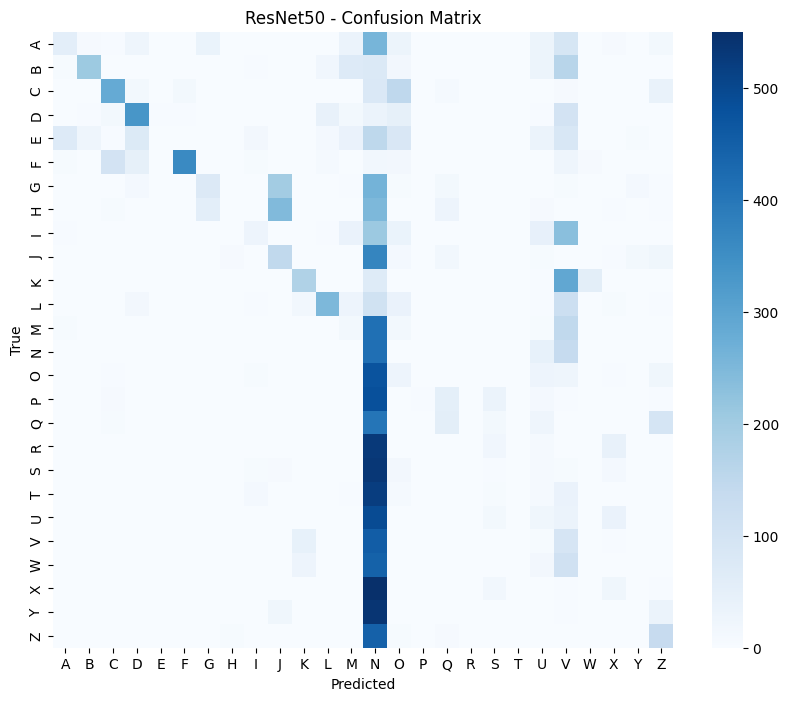

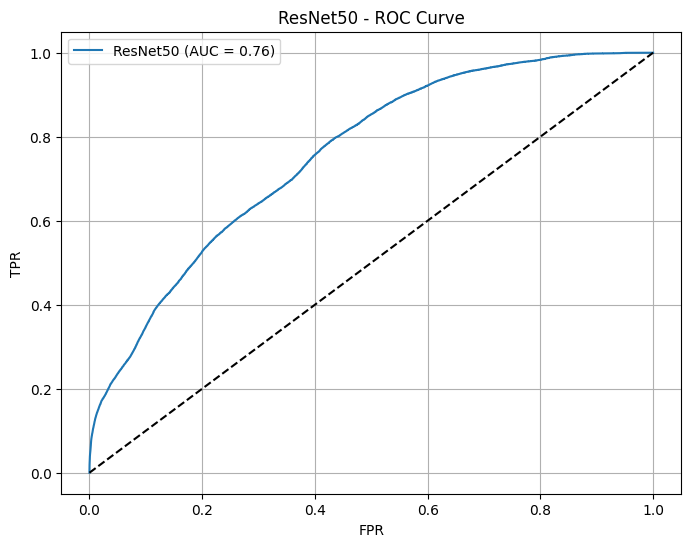

In [ ]:
def train_resnet():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n📌 ResNet50 Summary:")
    model.summary()

    start = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=10)
    print("⏱ Time taken:", round(time.time() - start, 2), "sec")

    plot_history(history, 'ResNet50')
    evaluate_model(model, val_data, 'ResNet50')
    model.save("resnet50_asl.h5")
    return history.history['val_accuracy'][-1]

acc_resnet = train_resnet()

# MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

📌 MobileNetV2 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,425,306 (9.25 MB)

 Trainable params: 167,322 (653.60 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 132s 63ms/step - accuracy: 0.4009 - loss: 2.1421 - val_accuracy: 0.8010 - val_loss: 0.7542
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 118s 61ms/step - accuracy: 0.8751 - loss: 0.4257 - val_accuracy: 0.8189 - val_loss: 0.5998
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 138s 58ms/step - accuracy: 0.9275 - loss: 0.2500 - val_accuracy: 0.8273 - val_loss: 0.5553
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 137s 70ms/step - accuracy: 0.9441 - loss: 0.1895 - val_accuracy: 0.8328 - val_loss: 0.5403
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 116s 60ms/step - accuracy: 0.9534 - loss: 0.1558 - val_accuracy: 0.8377 - val_loss: 0.5093
Epoch 6/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 120s 62ms/step - accuracy: 0.9592 - loss: 0.1350 - val_accuracy: 0.8396 - val_loss: 0.5193
Epoch 7/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 142s 62ms/step - accuracy: 0.9636 - loss: 0.1195 - val_accuracy: 0.8358 - val_loss: 0.5281
Epoch 8/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 116s 59ms/step - accuracy: 

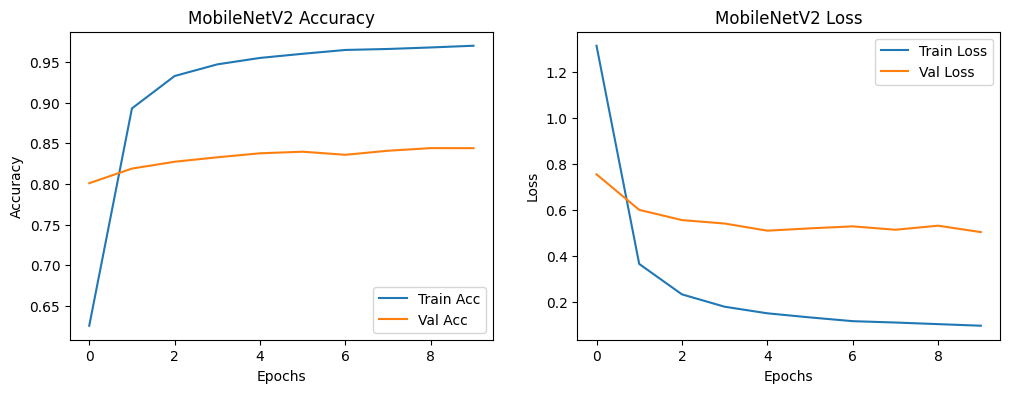

488/488 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step

📊 Classification Report - MobileNetV2
              precision    recall  f1-score   support

           A       0.88      0.96      0.92       600
           B       0.93      0.98      0.96       600
           C       0.96      0.99      0.98       600
           D       1.00      0.91      0.95       600
           E       0.79      0.95      0.86       600
           F       0.97      1.00      0.99       600
           G       0.88      0.86      0.87       600
           H       0.87      0.99      0.93       600
           I       0.98      0.70      0.82       600
           J       0.97      0.78      0.86       600
           K       0.97      0.89      0.93       600
           L       0.99      0.99      0.99       600
           M       0.70      0.90      0.79       600
           N       0.69      0.60      0.64       600
           O       0.81      0.83      0.82       600
           P       0.94      0.93      0.93       600

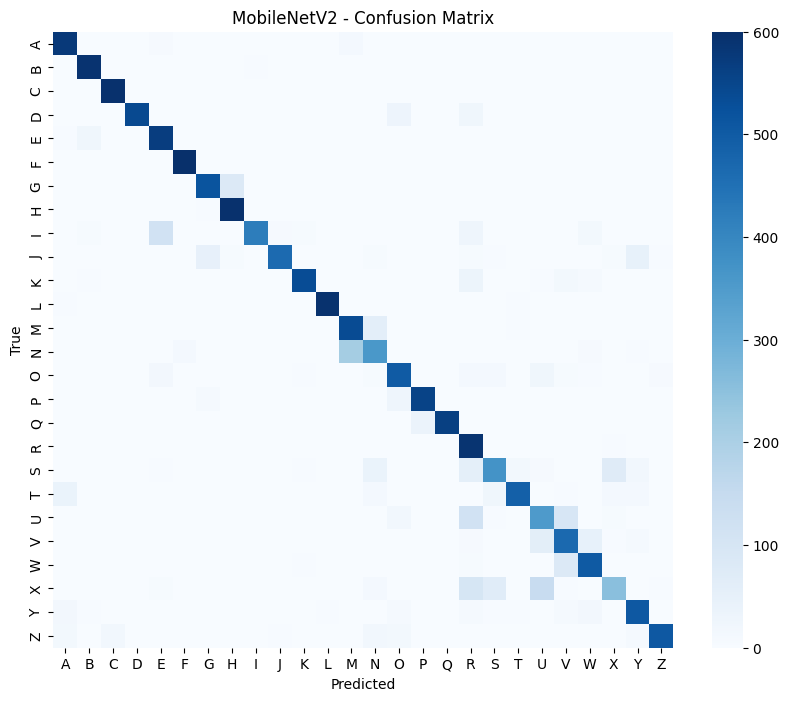

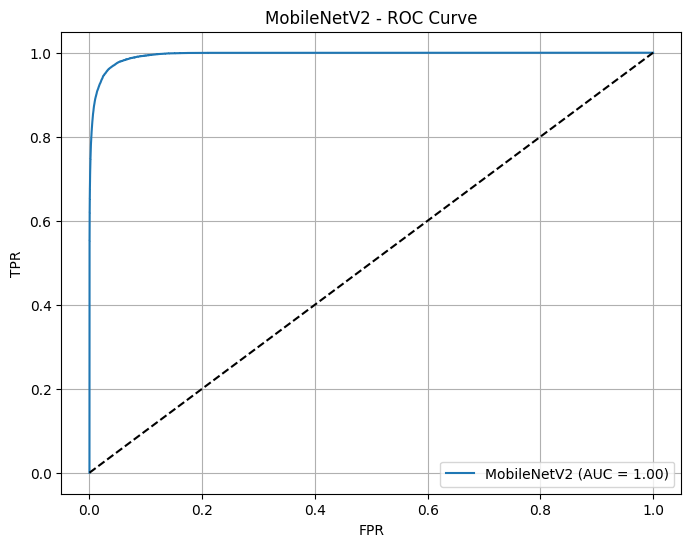

In [ ]:
def train_mobilenet():
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n📌 MobileNetV2 Summary:")
    model.summary()

    start = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=10)
    print("⏱ Time taken:", round(time.time() - start, 2), "sec")

    plot_history(history, 'MobileNetV2')
    evaluate_model(model, val_data, 'MobileNetV2')
    model.save("mobilenetv2_asl.h5")
    return history.history['val_accuracy'][-1]

acc_mobilenet = train_mobilenet()

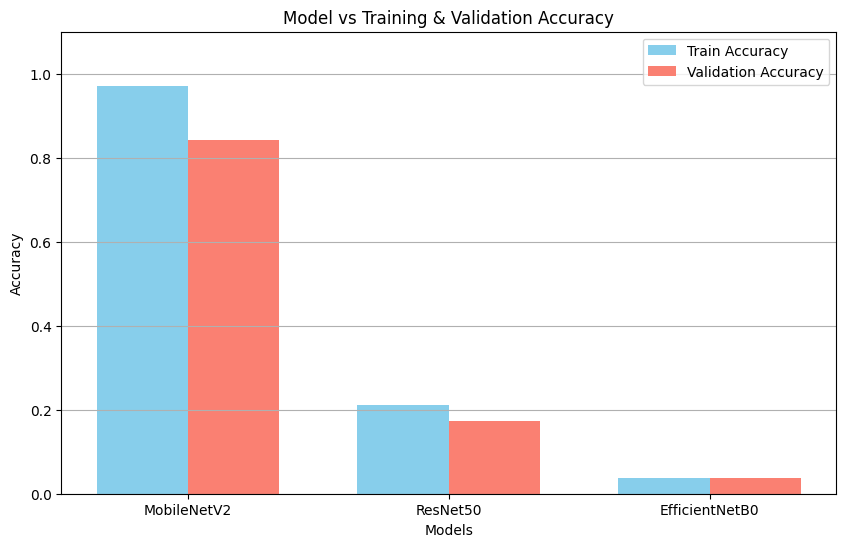

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['MobileNetV2', 'ResNet50', 'EfficientNetB0']

# Updated hardcoded accuracies
train_accuracies = [0.9701, 0.2121, 0.0377]
val_accuracies = [0.8429, 0.1741, 0.0385]

# Bar width and positions
bar_width = 0.35
x = range(len(models))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x, train_accuracies, width=bar_width, label='Train Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], val_accuracies, width=bar_width, label='Validation Accuracy', color='salmon')

# Labels and formatting
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model vs Training & Validation Accuracy')
plt.xticks([i + bar_width / 2 for i in x], models)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')

# Show plot
plt.show()
